## Importamos Librerias

In [94]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin

## Importamos funciones

In [95]:
def procesar_datos(df):

    # Eliminamos los itemos duplicados
    df_cat = df[["category", "item"]].drop_duplicates().reset_index(drop=True)

    # Contamos los items únicos
    df_items = df['item'].nunique()

    # Convertimos la columna de 'date' a tipo datetime y extrayendo columnas por año, mes, y día
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # Eliminamos columna 'yearweek'
    if 'yearweek' in df.columns:
        df.drop('yearweek', inplace=True, axis=1)

    # Agregando columnas nuevas que nos den información para el clustering
    aggregated_items = df.groupby('item').agg(
        max_price=('sell_price', 'max'),
        min_price=('sell_price', 'min'),
        mean_price=('sell_price', 'mean'),
        total_price=('sell_price', 'sum'),
        max_sales=('sales', 'max'),
        mean_sales=('sales', 'mean'),
        total_sales=('sales', 'sum'),
    ).reset_index()

    # Creamos otra columna, que sería el rango de precio
    aggregated_items["range_price"] = aggregated_items["max_price"] - aggregated_items["min_price"]

    # Creamos un DataFrame pivotado para las ventas por mes
    units_month = pd.pivot_table(df, values='sales', index='item', columns='month', aggfunc=sum, fill_value=0).reset_index()
    units_month.columns = units_month.columns.astype(str)

    # Fusionamos los DataFrames
    df_final = pd.merge(aggregated_items, units_month, on="item", how='inner')
    df_final = pd.merge(df_final, df_cat, on="item", how='inner')

    return df_final

In [96]:
def escalado(df):

    df_resultado = df.copy()

    features = df_resultado

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(features)

    return df_scaled

In [97]:
def grafica(df):

    wcss = []
    for i in range(1, 11):
           kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
           kmeans.fit(df)
           wcss.append(kmeans.inertia_)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method For Optimal Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.show()


In [98]:
def aplicar_kmeans(df, features_scaled, n_clusters=3):

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    df['cluster'] = clusters

    cluster_distribution = df['cluster'].value_counts()

    return df, cluster_distribution

## Cargamos el dataset

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
df = pd.read_csv('/content/drive/MyDrive/NUCLIO DIGITAL SCHOOL/TFM/Merged_datasets/df_merge_total.csv')

In [101]:
df.head()

,id,item,category,department,store,store_code,d,sales,yearweek,sell_price,date,weekday,event
0,ACCESORIES_1_008_NYC_1,ACCESORIES_1_008,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,d_1,12,201105.0,0.6118,2011-01-29,Saturday,Weekend
1,ACCESORIES_1_009_NYC_1,ACCESORIES_1_009,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,d_1,2,201105.0,2.0748,2011-01-29,Saturday,Weekend
2,ACCESORIES_1_010_NYC_1,ACCESORIES_1_010,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,d_1,0,201105.0,4.2161,2011-01-29,Saturday,Weekend
3,ACCESORIES_1_012_NYC_1,ACCESORIES_1_012,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,d_1,0,201105.0,7.9534,2011-01-29,Saturday,Weekend
4,ACCESORIES_1_015_NYC_1,ACCESORIES_1_015,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,d_1,4,201105.0,0.9310,2011-01-29,Saturday,Weekend


In [102]:
df.isnull().sum()

id            0
item          0
category      0
department    0
store         0
store_code    0
d             0
sales         0
yearweek      0
sell_price    0
date          0
weekday       0
event         0
dtype: int64

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46027957 entries, 0 to 46027956
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   item        object 
 2   category    object 
 3   department  object 
 4   store       object 
 5   store_code  object 
 6   d           object 
 7   sales       int64  
 8   yearweek    float64
 9   sell_price  float64
 10  date        object 
 11  weekday     object 
 12  event       object 
dtypes: float64(2), int64(1), object(10)
memory usage: 4.5+ GB


In [104]:
df_final = procesar_datos(df)

In [105]:
df_final.head()

,item,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,...,4,5,6,7,8,9,10,11,12,category
0,ACCESORIES_1_001,12.7414,6.6500,11.032747,111276.2854,6,0.405810,4093,6.0914,375,...,345,217,218,329,291,331,384,411,404,ACCESORIES
1,ACCESORIES_1_002,5.2801,2.6600,5.276608,97210.9502,11,0.274602,5059,2.6201,312,...,306,299,371,418,444,431,467,413,884,ACCESORIES
2,ACCESORIES_1_003,7.9401,1.2502,3.943978,30530.3362,6,0.185377,1435,6.6899,100,...,167,98,94,102,110,106,60,75,201,ACCESORIES
3,ACCESORIES_1_004,6.1712,5.0141,5.982920,113531.8856,25,2.064450,39175,1.1571,3481,...,3544,3320,3235,2899,3058,2981,3081,3167,3274,ACCESORIES
4,ACCESORIES_1_005,4.0964,1.9950,3.833668,69044.3565,15,0.811827,14621,2.1014,1388,...,827,941,1177,1196,1275,1241,1570,1439,1462,ACCESORIES


In [106]:
df_final.shape

(3049, 22)

In [107]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item         3049 non-null   object 
 1   max_price    3049 non-null   float64
 2   min_price    3049 non-null   float64
 3   mean_price   3049 non-null   float64
 4   total_price  3049 non-null   float64
 5   max_sales    3049 non-null   int64  
 6   mean_sales   3049 non-null   float64
 7   total_sales  3049 non-null   int64  
 8   range_price  3049 non-null   float64
 9   1            3049 non-null   int64  
 10  2            3049 non-null   int64  
 11  3            3049 non-null   int64  
 12  4            3049 non-null   int64  
 13  5            3049 non-null   int64  
 14  6            3049 non-null   int64  
 15  7            3049 non-null   int64  
 16  8            3049 non-null   int64  
 17  9            3049 non-null   int64  
 18  10           3049 non-null   int64  
 19  11    

In [108]:
df_final2 = df_final.copy()

## Separamos los datasets por su categoria

In [109]:
# Dataset con accesorios
df_acc = df_final2[df_final2["category"]=="ACCESORIES"]
df_acc = df_acc.drop("category", axis=1)
df_acc = df_acc.set_index("item")
df_acc

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,3,4,5,6,7,8,9,10,11,12
item,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,12.7414,6.6500,11.032747,111276.2854,6,0.405810,4093,6.0914,375,368,420,345,217,218,329,291,331,384,411,404
ACCESORIES_1_002,5.2801,2.6600,5.276608,97210.9502,11,0.274602,5059,2.6201,312,347,367,306,299,371,418,444,431,467,413,884
ACCESORIES_1_003,7.9401,1.2502,3.943978,30530.3362,6,0.185377,1435,6.6899,100,148,174,167,98,94,102,110,106,60,75,201
ACCESORIES_1_004,6.1712,5.0141,5.982920,113531.8856,25,2.064450,39175,1.1571,3481,3400,3735,3544,3320,3235,2899,3058,2981,3081,3167,3274
ACCESORIES_1_005,4.0964,1.9950,3.833668,69044.3565,15,0.811827,14621,2.1014,1388,1091,1014,827,941,1177,1196,1275,1241,1570,1439,1462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACCESORIES_2_145,3.8304,3.0989,3.683060,68420.2008,10,0.288367,5357,0.7315,562,581,673,509,435,435,354,476,378,347,301,306
ACCESORIES_2_146,2.6201,1.3300,2.618669,49581.8813,10,0.222774,4218,1.2901,291,275,391,334,389,384,371,373,398,416,323,273
ACCESORIES_2_147,1.2901,1.2901,1.290100,13084.1942,13,0.312069,3165,0.0000,232,274,299,280,248,187,264,272,267,287,288,267


In [110]:
# Dataset con cosas de jardineria y de casa
df_home = df_final2[df_final2["category"]=="HOME_&_GARDEN"]
df_home = df_home.drop("category", axis=1)
df_home = df_home.set_index("item")
df_home

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,3,4,5,6,7,8,9,10,11,12
item,,,,,,,,,,,,,,,,,,,,
HOME_&_GARDEN_1_001,9.1500,3.1250,7.598076,144606.5875,8,0.302070,5749,6.0250,482,547,507,533,424,471,494,514,538,452,384,403
HOME_&_GARDEN_1_002,9.1500,3.7500,7.585677,142193.5125,13,0.459696,8617,5.4000,841,881,837,756,570,772,782,747,681,580,545,625
HOME_&_GARDEN_1_003,11.2125,11.2125,11.212500,129493.1625,15,0.944757,10911,0.0000,969,907,910,778,756,901,859,1531,945,788,824,743
HOME_&_GARDEN_1_004,2.9625,2.3375,2.744538,52464.5875,36,1.624817,31060,0.6250,3095,2858,2254,2102,1635,1725,1896,2170,2558,3733,3834,3200
HOME_&_GARDEN_1_005,13.4000,6.1000,12.556882,233884.4875,13,0.969935,18066,7.3000,1512,2080,1878,1629,1258,1460,1427,1211,1066,1286,1585,1674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOME_&_GARDEN_2_512,5.3375,3.3375,4.962454,94723.3250,17,0.605354,11555,2.0000,803,893,1038,1072,1156,1213,1194,992,859,796,761,778
HOME_&_GARDEN_2_513,3.4750,3.4750,3.475000,38819.2250,20,0.708621,7916,0.0000,658,602,754,688,657,705,762,714,633,612,499,632
HOME_&_GARDEN_2_514,26.2125,1.2500,23.466717,448425.5000,5,0.164844,3150,24.9625,301,289,311,253,202,239,242,246,249,258,294,266


In [111]:
# Dataset con productos de supermercado
df_super = df_final2[df_final2["category"]=="SUPERMARKET"]
df_super= df_super.drop("category", axis=1)
df_super = df_super.set_index("item")
df_super

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,3,4,5,6,7,8,9,10,11,12
item,,,,,,,,,,,,,,,,,,,,
SUPERMARKET_1_001,2.688,1.188,2.597139,49665.084,24,0.640433,12247,1.500,831,1297,1238,1167,1147,1068,1030,927,896,803,890,953
SUPERMARKET_1_002,11.376,9.192,10.699792,204612.120,8,0.383517,7334,2.184,555,652,705,721,639,603,547,623,593,593,541,562
SUPERMARKET_1_003,3.876,3.000,3.560471,68111.808,22,0.700157,13394,0.876,986,1111,1373,1219,1122,1161,1100,1083,1115,1139,961,1024
SUPERMARKET_1_004,2.352,1.800,2.213155,33507.168,116,8.552246,129481,0.552,10360,9892,13918,13325,13889,11431,12828,10303,9578,7858,7011,9088
SUPERMARKET_1_005,4.248,0.120,3.987178,76190.976,30,1.199121,22914,4.128,2226,2857,2539,1778,717,366,361,1497,2845,2821,2140,2767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,3.576,1.188,3.346839,61190.256,25,0.841656,15388,2.388,1129,1696,1644,1204,891,911,1006,1433,1400,1231,1372,1471
SUPERMARKET_3_824,3.216,2.400,3.026944,57905.448,18,0.435180,8325,0.816,456,678,784,897,806,984,783,709,669,659,473,427
SUPERMARKET_3_825,5.256,2.388,4.934360,94290.684,20,0.707834,13526,2.868,1028,1649,1447,1312,1002,944,1297,1165,1054,915,758,955


## Accesorios

In [112]:
df_scaled = escalado(df_acc)

In [113]:
df_acc.shape

(565, 20)

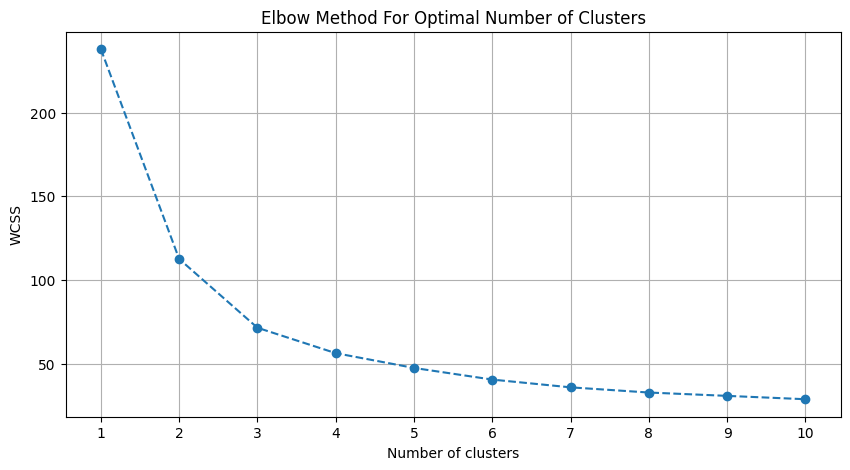

In [114]:
grafica(df_scaled)

In [115]:
aplicar_kmeans(df_acc,df_scaled,n_clusters=3)

(                  max_price  min_price  mean_price  total_price  max_sales  \
 item                                                                         
 ACCESORIES_1_001    12.7414     6.6500   11.032747  111276.2854          6   
 ACCESORIES_1_002     5.2801     2.6600    5.276608   97210.9502         11   
 ACCESORIES_1_003     7.9401     1.2502    3.943978   30530.3362          6   
 ACCESORIES_1_004     6.1712     5.0141    5.982920  113531.8856         25   
 ACCESORIES_1_005     4.0964     1.9950    3.833668   69044.3565         15   
 ...                     ...        ...         ...          ...        ...   
 ACCESORIES_2_145     3.8304     3.0989    3.683060   68420.2008         10   
 ACCESORIES_2_146     2.6201     1.3300    2.618669   49581.8813         10   
 ACCESORIES_2_147     1.2901     1.2901    1.290100   13084.1942         13   
 ACCESORIES_2_148     1.5561     1.0241    1.120607   21264.6385         12   
 ACCESORIES_2_149     3.2851     0.6650    2.029600 

In [116]:
df_acc.head()

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,...,4,5,6,7,8,9,10,11,12,cluster
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,12.7414,6.6500,11.032747,111276.2854,6,0.405810,4093,6.0914,375,368,...,345,217,218,329,291,331,384,411,404,2
ACCESORIES_1_002,5.2801,2.6600,5.276608,97210.9502,11,0.274602,5059,2.6201,312,347,...,306,299,371,418,444,431,467,413,884,2
ACCESORIES_1_003,7.9401,1.2502,3.943978,30530.3362,6,0.185377,1435,6.6899,100,148,...,167,98,94,102,110,106,60,75,201,2
ACCESORIES_1_004,6.1712,5.0141,5.982920,113531.8856,25,2.064450,39175,1.1571,3481,3400,...,3544,3320,3235,2899,3058,2981,3081,3167,3274,1
ACCESORIES_1_005,4.0964,1.9950,3.833668,69044.3565,15,0.811827,14621,2.1014,1388,1091,...,827,941,1177,1196,1275,1241,1570,1439,1462,2


In [117]:
df_acc.to_csv('acc_clusters.csv')

## Ficha de los resultados de Accesorios

In [118]:
(
    df_acc
    .groupby('cluster')
    .describe()
    .T
    .style.background_gradient(cmap = 'Blues', axis = 1)
)

In [119]:
dfs_acc = []

for i, col in enumerate(["total_sales","mean_price","range_price", "max_price"]):
    resumen_data = df_acc[["cluster", col]].groupby("cluster").describe().T[1:]
    dfs_acc.append(resumen_data)

ficha_df_acc = pd.concat(dfs_acc)

ficha_df_acc

cluster                      0              1             2
total_sales mean   7312.224000   64593.975000   6567.532500
            std    6339.323174   20691.001470   6201.224001
            min     886.000000   37267.000000    660.000000
            25%    2764.000000   49324.750000   2225.500000
            50%    4694.000000   59031.500000   4339.500000
            75%   10609.000000   76568.000000   8887.500000
            max   29320.000000  122565.000000  34880.000000
mean_price  mean     17.854657       1.435704      4.715855
            std       6.355912       2.281895      2.996575
            min      10.140878       0.396563      0.305900
            25%      13.931194       0.632719      2.292245
            50%      16.207978       0.742483      3.956983
            75%      19.690982       0.942822      6.608343
            max      39.494669      13.370902     13.248082
range_price mean      4.984308       0.445883      1.547122
            std       4.454194       0.452731      1.841200
            min       0.000000       0.000000      0.000000
            25%       2.048200       0.199500      0.133000
            50%       3.670800       0.339150      0.950950
            75%       7.155400       0.455525      2.423925
            max      24.445400       2.261000     10.919300
max_price   mean     18.666071       1.578377      4.961432
            std       6.594916       2.581896      3.099074
            min      10.613400       0.399000      0.305900
            25%      14.603400       0.665000      2.354100
            50%      16.864400       0.771400      4.448850
            75%      21.053900       1.103900      7.092225
            max      41.203400      15.521100     13.273400

In [120]:
# generamos nuestro multiindex
out_index = [
    "Cantidad",
    "Monetario",
    "Monetario",
    "Monetario"
]

inner_index = [
    "Total Unidades",
    "Precio Promedio",
    "Rango de precio",
    "Precio Máximo",
    "Precio Mínimo"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [121]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [122]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df_acc.set_index(index_ficha, inplace = True)

In [123]:
tamaño_clusters = df_acc.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [124]:
ficha_df = pd.concat([tamaño_clusters, ficha_df_acc])

In [125]:
ficha_df

cluster                                                   0              1  \
Grupo Indicadores Indicador       Estadístico                                
General           Clúster         Tamaño         125.000000      40.000000   
Cantidad          Total Unidades  Media         7312.224000   64593.975000   
                                  Desviación    6339.323174   20691.001470   
                                  Mínimo         886.000000   37267.000000   
                                  Perc. 25      2764.000000   49324.750000   
                                  Perc. 50      4694.000000   59031.500000   
                                  Perc. 75     10609.000000   76568.000000   
                                  Máximo       29320.000000  122565.000000   
Monetario         Precio Promedio Media           17.854657       1.435704   
                                  Desviación       6.355912       2.281895   
                                  Mínimo          10.140878       0.396563   
                                  Perc. 25        13.931194       0.632719   
                                  Perc. 50        16.207978       0.742483   
                                  Perc. 75        19.690982       0.942822   
                                  Máximo          39.494669      13.370902   
                  Rango de precio Media            4.984308       0.445883   
                                  Desviación       4.454194       0.452731   
                                  Mínimo           0.000000       0.000000   
                                  Perc. 25         2.048200       0.199500   
                                  Perc. 50         3.670800       0.339150   
                                  Perc. 75         7.155400       0.455525   
                                  Máximo          24.445400       2.261000   
                  Precio Máximo   Media           18.666071       1.578377   
                                  Desviación       6.594916       2.581896   
                                  Mínimo          10.613400       0.399000   
                                  Perc. 25        14.603400       0.665000   
                                  Perc. 50        16.864400       0.771400   
                                  Perc. 75        21.053900       1.103900   
                                  Máximo          41.203400      15.521100   

cluster                                                   2  
Grupo Indicadores Indicador       Estadístico                
General           Clúster         Tamaño         400.000000  
Cantidad          Total Unidades  Media         6567.532500  
                                  Desviación    6201.224001  
                                  Mínimo         660.000000  
                                  Perc. 25      2225.500000  
                                  Perc. 50      4339.500000  
                                  Perc. 75      8887.500000  
                                  Máximo       34880.000000  
Monetario         Precio Promedio Media            4.715855  
                                  Desviación       2.996575  
                                  Mínimo           0.305900  
                                  Perc. 25         2.292245  
                                  Perc. 50         3.956983  
                                  Perc. 75         6.608343  
                                  Máximo          13.248082  
                  Rango de precio Media            1.547122  
                                  Desviación       1.841200  
                                  Mínimo           0.000000  
                                  Perc. 25         0.133000  
                                  Perc. 50         0.950950  
                                  Perc. 75         2.423925  
                                  Máximo          10.919300  
                  Precio Máximo   Media            4.961432  
                               

In [126]:
ficha_df = ficha_df.rename(columns = {
    0 : "Items Premium",
    1 : "Items Top Sales",
    2 : "Items Medium Sales"
})

In [127]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

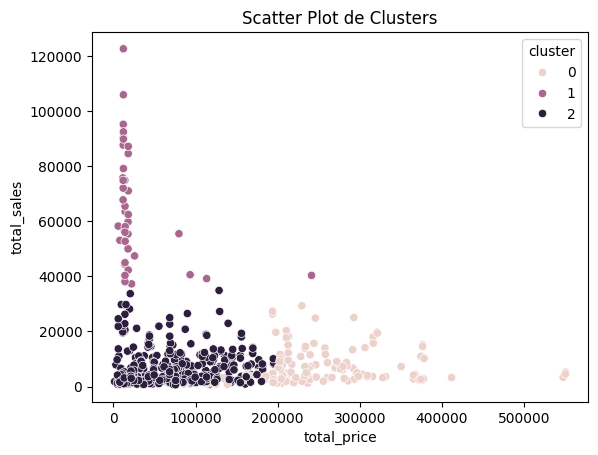

In [128]:
sns.scatterplot(x='total_price', y='total_sales', hue='cluster', data=df_acc)
plt.title('Scatter Plot de Clusters')
plt.show()

In [129]:
'''
Los Items Premium parecen ser productos de alto valor, posiblemente de lujo o alta gama, que se venden
a precios más altos con una variabilidad significativa, reflejando la exclusividad o calidad superior.

Los Items Top Sales podrían ser productos que, aunque son menos en número, tienen la capacidad de alcanzar precios
máximos muy altos, posiblemente debido a una demanda estacional o a lanzamientos de ediciones limitadas.

Los Items Medium Sales parecen ser los más comunes o estándar, con un número más alto de productos y una distribución de ventas más homogénea.

'''

'\nLos Items Premium parecen ser productos de alto valor, posiblemente de lujo o alta gama, que se venden \na precios más altos con una variabilidad significativa, reflejando la exclusividad o calidad superior.\n\nLos Items Top Sales podrían ser productos que, aunque son menos en número, tienen la capacidad de alcanzar precios \nmáximos muy altos, posiblemente debido a una demanda estacional o a lanzamientos de ediciones limitadas.\n\nLos Items Medium Sales parecen ser los más comunes o estándar, con un número más alto de productos y una distribución de ventas más homogénea.\n\n'

## Home & Gardens

In [130]:
df_home.head()

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,3,4,5,6,7,8,9,10,11,12
item,,,,,,,,,,,,,,,,,,,,
HOME_&_GARDEN_1_001,9.1500,3.1250,7.598076,144606.5875,8,0.302070,5749,6.025,482,547,507,533,424,471,494,514,538,452,384,403
HOME_&_GARDEN_1_002,9.1500,3.7500,7.585677,142193.5125,13,0.459696,8617,5.400,841,881,837,756,570,772,782,747,681,580,545,625
HOME_&_GARDEN_1_003,11.2125,11.2125,11.212500,129493.1625,15,0.944757,10911,0.000,969,907,910,778,756,901,859,1531,945,788,824,743
HOME_&_GARDEN_1_004,2.9625,2.3375,2.744538,52464.5875,36,1.624817,31060,0.625,3095,2858,2254,2102,1635,1725,1896,2170,2558,3733,3834,3200
HOME_&_GARDEN_1_005,13.4000,6.1000,12.556882,233884.4875,13,0.969935,18066,7.300,1512,2080,1878,1629,1258,1460,1427,1211,1066,1286,1585,1674


In [131]:
df_scaled_home = escalado(df_home)

In [132]:
df_scaled_home.shape

(1047, 20)

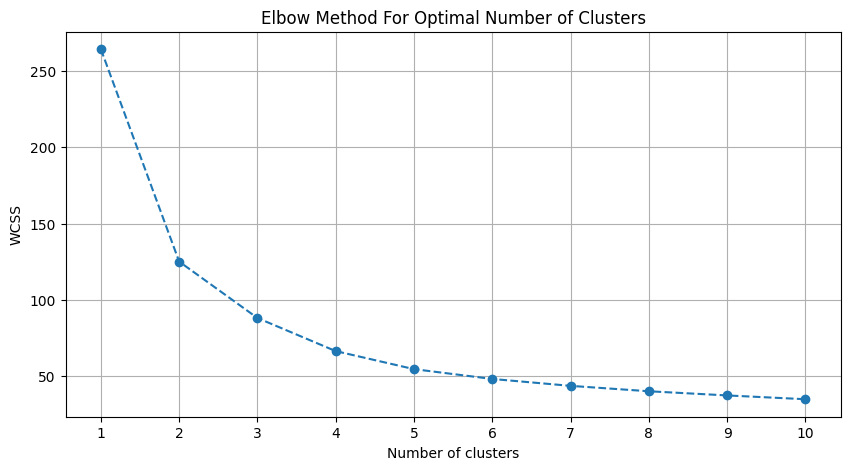

In [133]:
grafica(df_scaled_home)

In [134]:
aplicar_kmeans(df_home,df_scaled_home,n_clusters=3)

(                     max_price  min_price  mean_price  total_price  max_sales  \
 item                                                                            
 HOME_&_GARDEN_1_001     9.1500     3.1250    7.598076  144606.5875          8   
 HOME_&_GARDEN_1_002     9.1500     3.7500    7.585677  142193.5125         13   
 HOME_&_GARDEN_1_003    11.2125    11.2125   11.212500  129493.1625         15   
 HOME_&_GARDEN_1_004     2.9625     2.3375    2.744538   52464.5875         36   
 HOME_&_GARDEN_1_005    13.4000     6.1000   12.556882  233884.4875         13   
 ...                        ...        ...         ...          ...        ...   
 HOME_&_GARDEN_2_512     5.3375     3.3375    4.962454   94723.3250         17   
 HOME_&_GARDEN_2_513     3.4750     3.4750    3.475000   38819.2250         20   
 HOME_&_GARDEN_2_514    26.2125     1.2500   23.466717  448425.5000          5   
 HOME_&_GARDEN_2_515     2.4625     1.2250    2.461467   20639.4000          6   
 HOME_&_GARDEN_2

In [135]:
df_home.to_csv('home_clusters.csv')

## Ficha de los resultados de Items caseros y de jardineria

In [136]:
(
    df_home
    .groupby('cluster')
    .describe()
    .T
    .style.background_gradient(cmap = 'Reds', axis = 1)
)

In [137]:
dfs_home = []
for i, col in enumerate(["total_sales","mean_price","range_price","max_price"]):
    resumen_data = df_home[["cluster", col]].groupby("cluster").describe().T[1:]
    dfs_home.append(resumen_data)  # Agrega cada DataFrame a la lista
ficha_df_home = pd.concat(dfs_home)
ficha_df_home

cluster                      0             1              2
total_sales mean   7018.677382  35016.574324  113748.178571
            std    5017.860363  13417.977010   26793.471914
            min     568.000000  18279.000000   73430.000000
            25%    3039.000000  24350.750000   97178.250000
            50%    5749.000000  31503.500000  111832.000000
            75%    9682.000000  40449.000000  125263.500000
            max   22696.000000  72525.000000  171275.000000
mean_price  mean      7.428597      4.026312       2.081731
            std       4.300476      2.749803       1.780292
            min       1.167797      0.975000       1.157998
            25%       4.688131      2.424686       1.208656
            50%       6.357325      3.445430       1.220621
            75%       8.947772      4.858568       1.567750
            max      37.428478     18.788013       8.703745
range_price mean      3.578042      1.550507       0.377232
            std       6.124081      1.617552       0.714241
            min       0.000000      0.000000       0.000000
            25%       0.625000      0.175000       0.025000
            50%       2.500000      1.212500       0.175000
            75%       4.956250      2.481250       0.587500
            max     130.075000      6.850000       3.750000
max_price   mean      8.064552      4.252449       2.178571
            std       6.815106      2.883724       1.857856
            min       1.212500      0.975000       1.212500
            25%       4.943750      2.462500       1.225000
            50%       6.837500      3.625000       1.225000
            75%       9.587500      5.053125       1.937500
            max     134.150000     19.337500       8.712500

In [138]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df_home.set_index(index_ficha, inplace = True)

In [139]:
tamaño_clusters = df_home.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [140]:
ficha_df_home = pd.concat([tamaño_clusters, ficha_df_home])


In [141]:
ficha_df_home

cluster                                                   0             1  \
Grupo Indicadores Indicador       Estadístico                               
General           Clúster         Tamaño         871.000000    148.000000   
Cantidad          Total Unidades  Media         7018.677382  35016.574324   
                                  Desviación    5017.860363  13417.977010   
                                  Mínimo         568.000000  18279.000000   
                                  Perc. 25      3039.000000  24350.750000   
                                  Perc. 50      5749.000000  31503.500000   
                                  Perc. 75      9682.000000  40449.000000   
                                  Máximo       22696.000000  72525.000000   
Monetario         Precio Promedio Media            7.428597      4.026312   
                                  Desviación       4.300476      2.749803   
                                  Mínimo           1.167797      0.975000   
                                  Perc. 25         4.688131      2.424686   
                                  Perc. 50         6.357325      3.445430   
                                  Perc. 75         8.947772      4.858568   
                                  Máximo          37.428478     18.788013   
                  Rango de precio Media            3.578042      1.550507   
                                  Desviación       6.124081      1.617552   
                                  Mínimo           0.000000      0.000000   
                                  Perc. 25         0.625000      0.175000   
                                  Perc. 50         2.500000      1.212500   
                                  Perc. 75         4.956250      2.481250   
                                  Máximo         130.075000      6.850000   
                  Precio Máximo   Media            8.064552      4.252449   
                                  Desviación       6.815106      2.883724   
                                  Mínimo           1.212500      0.975000   
                                  Perc. 25         4.943750      2.462500   
                                  Perc. 50         6.837500      3.625000   
                                  Perc. 75         9.587500      5.053125   
                                  Máximo         134.150000     19.337500   

cluster                                                    2  
Grupo Indicadores Indicador       Estadístico                 
General           Clúster         Tamaño           28.000000  
Cantidad          Total Unidades  Media        113748.178571  
                                  Desviación    26793.471914  
                                  Mínimo        73430.000000  
                                  Perc. 25      97178.250000  
                                  Perc. 50     111832.000000  
                                  Perc. 75     125263.500000  
                                  Máximo       171275.000000  
Monetario         Precio Promedio Media             2.081731  
                                  Desviación        1.780292  
                                  Mínimo            1.157998  
                                  Perc. 25          1.208656  
                                  Perc. 50          1.220621  
                                  Perc. 75          1.567750  
                                  Máximo            8.703745  
                  Rango de precio Media             0.377232  
                                  Desviación        0.714241  
                                  Mínimo            0.000000  
                                  Perc. 25          0.025000  
                                  Perc. 50          0.175000  
                                  Perc. 75          0.587500  
                                  Máximo            3.750000  
                  Precio Máximo   Media             2.178571  
                                  Des

In [142]:
ficha_df_home = ficha_df_home.rename(columns = {
    0 : "Items Premium",
    1 : "Items Regulares",
    2 : "Items Top Sales"
})

In [143]:
ficha_df_home.style.background_gradient(cmap = 'Reds', axis = 1)

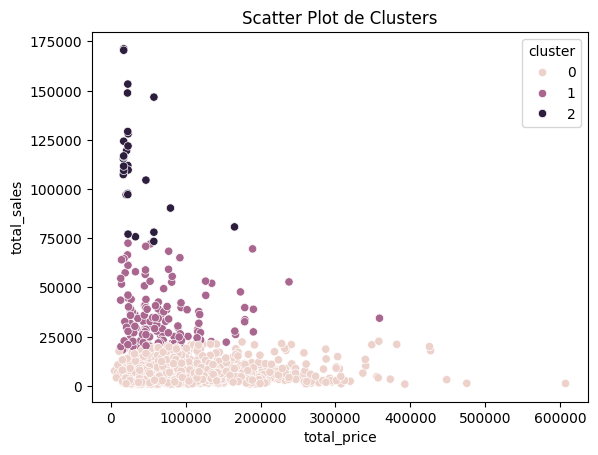

In [144]:
sns.scatterplot(x='total_price', y='total_sales', hue='cluster', data=df_home)
plt.title('Scatter Plot de Clusters')
plt.show()

In [145]:
'''
Items Premium: Este cluster podría estar compuesto por productos de lujo o de alta gama, que no solo tienen
un precio unitario alto en promedio sino también una variabilidad significativa, lo que sugiere una diversa gama de
productos con diferentes niveles de exclusividad o características premium.

Items Regulares: Parecen ser productos más estándar o de uso común, posiblemente los más numerosos en términos de
variedad o volumen, pero con precios y ventas más consistentes y predecibles.

Items Top Sales: Aunque no hay mucha información proporcionada, por su nombre, este grupo podría representar productos
que son líderes en ventas, ya sea en términos de volumen o ingresos. Dado que este cluster es el más pequeño en términos de tamaño,
estos podrían ser productos estrella o best-sellers.

'''

'\nItems Premium: Este cluster podría estar compuesto por productos de lujo o de alta gama, que no solo tienen \nun precio unitario alto en promedio sino también una variabilidad significativa, lo que sugiere una diversa gama de \nproductos con diferentes niveles de exclusividad o características premium.\n\nItems Regulares: Parecen ser productos más estándar o de uso común, posiblemente los más numerosos en términos de \nvariedad o volumen, pero con precios y ventas más consistentes y predecibles.\n\nItems Top Sales: Aunque no hay mucha información proporcionada, por su nombre, este grupo podría representar productos \nque son líderes en ventas, ya sea en términos de volumen o ingresos. Dado que este cluster es el más pequeño en términos de tamaño, \nestos podrían ser productos estrella o best-sellers.\n\n'

## Supermarket

In [146]:
df_super.head()

,max_price,min_price,mean_price,total_price,max_sales,mean_sales,total_sales,range_price,1,2,3,4,5,6,7,8,9,10,11,12
item,,,,,,,,,,,,,,,,,,,,
SUPERMARKET_1_001,2.688,1.188,2.597139,49665.084,24,0.640433,12247,1.500,831,1297,1238,1167,1147,1068,1030,927,896,803,890,953
SUPERMARKET_1_002,11.376,9.192,10.699792,204612.120,8,0.383517,7334,2.184,555,652,705,721,639,603,547,623,593,593,541,562
SUPERMARKET_1_003,3.876,3.000,3.560471,68111.808,22,0.700157,13394,0.876,986,1111,1373,1219,1122,1161,1100,1083,1115,1139,961,1024
SUPERMARKET_1_004,2.352,1.800,2.213155,33507.168,116,8.552246,129481,0.552,10360,9892,13918,13325,13889,11431,12828,10303,9578,7858,7011,9088
SUPERMARKET_1_005,4.248,0.120,3.987178,76190.976,30,1.199121,22914,4.128,2226,2857,2539,1778,717,366,361,1497,2845,2821,2140,2767


In [147]:
df_scaled_super = escalado(df_super)

In [148]:
df_scaled_super.shape

(1437, 20)

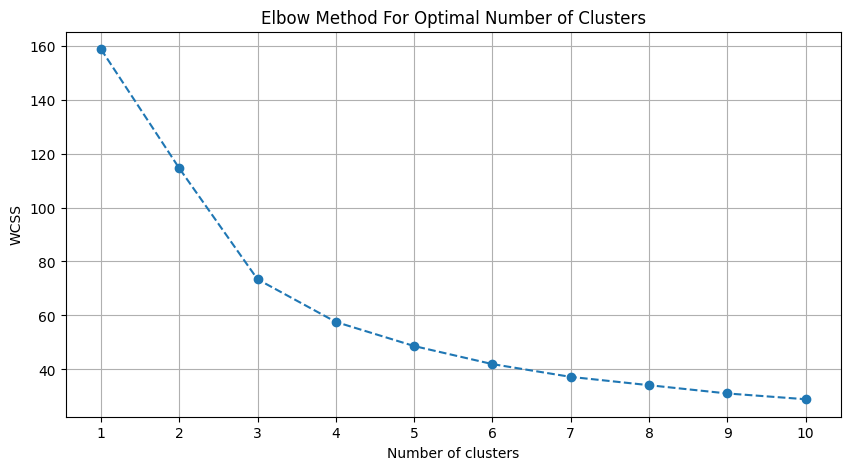

In [149]:
grafica(df_scaled_super)

In [150]:
aplicar_kmeans(df_super,df_scaled_super,n_clusters=4)

(                   max_price  min_price  mean_price  total_price  max_sales  \
 item                                                                          
 SUPERMARKET_1_001      2.688      1.188    2.597139    49665.084         24   
 SUPERMARKET_1_002     11.376      9.192   10.699792   204612.120          8   
 SUPERMARKET_1_003      3.876      3.000    3.560471    68111.808         22   
 SUPERMARKET_1_004      2.352      1.800    2.213155    33507.168        116   
 SUPERMARKET_1_005      4.248      0.120    3.987178    76190.976         30   
 ...                      ...        ...         ...          ...        ...   
 SUPERMARKET_3_823      3.576      1.188    3.346839    61190.256         25   
 SUPERMARKET_3_824      3.216      2.400    3.026944    57905.448         18   
 SUPERMARKET_3_825      5.256      2.388    4.934360    94290.684         20   
 SUPERMARKET_3_826      1.536      1.200    1.535785    16812.240         13   
 SUPERMARKET_3_827      1.200      0.600

In [151]:
df_super.to_csv('super_clusters.csv')

In [152]:
(
    df_super
    .groupby('cluster')
    .describe()
    .T
    .style.background_gradient(cmap = 'Oranges', axis = 1)
)

In [153]:
dfs_super = []
for i, col in enumerate(["total_sales","mean_price","range_price", "max_price"]):
    resumen_data = df_super[["cluster", col]].groupby("cluster").describe().T[1:]
    dfs_super.append(resumen_data)  # Agrega cada DataFrame a la lista
ficha_df_super = pd.concat(dfs_super)
ficha_df_super

cluster                       0              1              2             3
total_sales mean  174347.329412   16637.713004   20960.754667  7.448392e+05
            std    74012.450880   19719.522699   18935.682233  2.540955e+05
            min    52598.000000    1094.000000     823.000000  4.912870e+05
            25%   123389.000000    4771.000000    7679.000000  5.467960e+05
            50%   149465.000000    9140.000000   14888.000000  7.427705e+05
            75%   202238.000000   20092.500000   26994.000000  9.408138e+05
            max   396172.000000  105544.000000  100597.000000  1.002529e+06
mean_price  mean       1.878489       8.701838       3.169042  1.819353e+00
            std        1.186411       2.702143       1.168081  1.321629e-01
            min        0.239474       3.589825       0.854131  1.631535e+00
            25%        1.171813       7.135700       2.375092  1.774491e+00
            50%        1.626977       7.816378       3.005651  1.866994e+00
            75%        2.565327       9.637688       3.804216  1.911856e+00
            max        5.973673      22.565073       6.456291  1.911889e+00
range_price mean       0.687529       3.972646       1.410400  3.330000e-01
            std        0.649361       2.656559       1.033291  2.719485e-01
            min        0.000000       0.000000       0.000000  1.200000e-01
            25%        0.240000       1.920000       0.600000  2.100000e-01
            50%        0.576000       3.816000       1.248000  2.400000e-01
            75%        0.828000       5.376000       2.064000  3.630000e-01
            max        3.276000      17.376000       5.256000  7.320000e-01
max_price   mean       2.066118       9.626960       3.370496  1.962000e+00
            std        1.261058       2.843399       1.242987  6.311894e-02
            min        0.300000       6.312000       0.900000  1.896000e+00
            25%        1.200000       7.728000       2.400000  1.914000e+00
            50%        1.800000       8.964000       3.216000  1.968000e+00
            75%        2.856000      10.776000       4.176000  2.016000e+00
            max        5.976000      23.376000       6.756000  2.016000e+00

In [154]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df_super.set_index(index_ficha, inplace = True)

In [155]:
tamaño_clusters = df_super.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [156]:
ficha_df_super = pd.concat([tamaño_clusters, ficha_df_super])

In [157]:
ficha_df_super

cluster                                                    0              1  \
Grupo Indicadores Indicador       Estadístico                                 
General           Clúster         Tamaño           85.000000     223.000000   
Cantidad          Total Unidades  Media        174347.329412   16637.713004   
                                  Desviación    74012.450880   19719.522699   
                                  Mínimo        52598.000000    1094.000000   
                                  Perc. 25     123389.000000    4771.000000   
                                  Perc. 50     149465.000000    9140.000000   
                                  Perc. 75     202238.000000   20092.500000   
                                  Máximo       396172.000000  105544.000000   
Monetario         Precio Promedio Media             1.878489       8.701838   
                                  Desviación        1.186411       2.702143   
                                  Mínimo            0.239474       3.589825   
                                  Perc. 25          1.171813       7.135700   
                                  Perc. 50          1.626977       7.816378   
                                  Perc. 75          2.565327       9.637688   
                                  Máximo            5.973673      22.565073   
                  Rango de precio Media             0.687529       3.972646   
                                  Desviación        0.649361       2.656559   
                                  Mínimo            0.000000       0.000000   
                                  Perc. 25          0.240000       1.920000   
                                  Perc. 50          0.576000       3.816000   
                                  Perc. 75          0.828000       5.376000   
                                  Máximo            3.276000      17.376000   
                  Precio Máximo   Media             2.066118       9.626960   
                                  Desviación        1.261058       2.843399   
                                  Mínimo            0.300000       6.312000   
                                  Perc. 25          1.200000       7.728000   
                                  Perc. 50          1.800000       8.964000   
                                  Perc. 75          2.856000      10.776000   
                                  Máximo            5.976000      23.376000   

cluster                                                    2             3  
Grupo Indicadores Indicador       Estadístico                               
General           Clúster         Tamaño         1125.000000  4.000000e+00  
Cantidad          Total Unidades  Media         20960.754667  7.448392e+05  
                                  Desviación    18935.682233  2.540955e+05  
                                  Mínimo          823.000000  4.912870e+05  
                                  Perc. 25       7679.000000  5.467960e+05  
                                  Perc. 50      14888.000000  7.427705e+05  
                                  Perc. 75      26994.000000  9.408138e+05  
                                  Máximo       100597.000000  1.002529e+06  
Monetario         Precio Promedio Media             3.169042  1.819353e+00  
                                  Desviación        1.168081  1.321629e-01  
                                  Mínimo            0.854131  1.631535e+00  
                                  Perc. 25          2.375092  1.774491e+00  
                                  Perc. 50          3.005651  1.866994e+00  
                                  Perc. 75          3.804216  1.911856e+00  
                                  Máximo            6.456291  1.911889e+00  
                  Rango de precio Media             1.410400  3.330000e-01  
                                  Desviación        1.033291  2.719485e-01  
                                  Mínimo            0.000000  1.200000e-01  
          

In [158]:
ficha_df_super = ficha_df_super.rename(columns = {
    0 : "Populares",
    1 : "Premium",
    2 : "Complementarios",
    3 : "Primera necesidad"
})

In [159]:
ficha_df_super.style.background_gradient(cmap = 'Oranges', axis = 1)

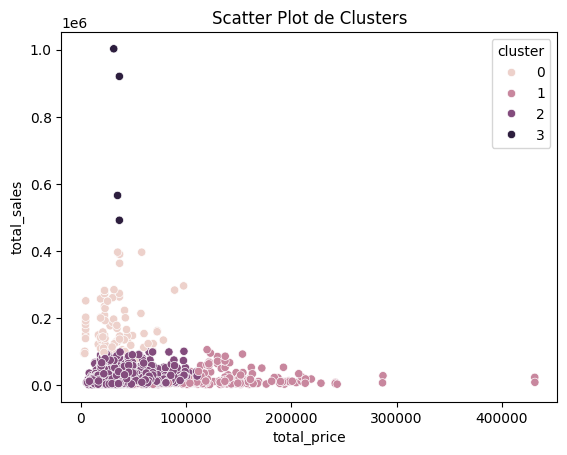

In [160]:
sns.scatterplot(x='total_price', y='total_sales', hue='cluster', data=df_super)
plt.title('Scatter Plot de Clusters')
plt.show()

In [161]:
'''
Populares: Incluye una amplia gama de productos, con algunos alcanzando altas
unidades de venta o stock, pero con precios promedio y máximos más contenidos.

Premium: Consiste en productos de alto valor, con una gran variabilidad en precios y cantidades,
posiblemente debido a la exclusividad o especialización de estos artículos.

Complementarios: Parece tener un rango de precios variable y precios máximos altos, lo que podría reflejar
que estos productos se venden con frecuencia junto con otros artículos, potencialmente en una amplia gama de precios.

Primera necesidad: Con el mayor tamaño del cluster y una alta cantidad de unidades, estos productos son probablemente
esenciales y comprados regularmente, resultando en un stock o volumen de ventas elevado.

'''

'\nPopulares: Incluye una amplia gama de productos, con algunos alcanzando altas \nunidades de venta o stock, pero con precios promedio y máximos más contenidos.\n\nPremium: Consiste en productos de alto valor, con una gran variabilidad en precios y cantidades,\nposiblemente debido a la exclusividad o especialización de estos artículos.\n\nComplementarios: Parece tener un rango de precios variable y precios máximos altos, lo que podría reflejar \nque estos productos se venden con frecuencia junto con otros artículos, potencialmente en una amplia gama de precios.\n\nPrimera necesidad: Con el mayor tamaño del cluster y una alta cantidad de unidades, estos productos son probablemente \nesenciales y comprados regularmente, resultando en un stock o volumen de ventas elevado.\n\n'